In [1]:
%cd ..

/home/dawood/Workspace/compoundGAN


In [3]:
import os
import sys

import torch
import joypy
import dgl
import random
import networkx as nx
import numpy as np

from tqdm.notebook import tqdm 
from collections import defaultdict

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import RDConfig
from rdkit.Chem import QED

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

import selfies
from selfies import encoder as selfies_encoder
from selfies import decoder as selfies_decoder
from data.selfies import SELFIES, SELFIE_VOCAB, SELFIES_STEREO
#from data.zinc import ZINC250K

from models.network import CVAEF

from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

DEVICE = torch.device('cuda:0')

random.seed(42)

In [4]:
dataset = SELFIES('/home/dawood/Datasets/ZINC250K/data.csv')
dataset_smiles = []
dataset_logP = []
dataset_tpsa = []
dataset_qed = []
dataset_sas = []

for smiles in tqdm(dataset.data):
    mol = Chem.MolFromSmiles(smiles)
    Chem.Kekulize(mol)
    smiles = Chem.CanonSmiles(Chem.MolToSmiles(mol))
    dataset_smiles.append(smiles)
    
    logP = Descriptors.MolLogP(mol)
    dataset_logP.append(logP)
    
    tpsa = Descriptors.TPSA(mol)
    dataset_tpsa.append(tpsa / 10.0)
    
    sascore = sascorer.calculateScore(mol)
    dataset_sas.append(sascore)

# dataset = ZINC250K('/home/dawood/Datasets/ZINC250K/data.csv')
# for smiles, logp, qed, sas in tqdm(dataset.data):
#     dataset_smiles.append(smiles)
#     dataset_logP.append(logp)
#     dataset_qed.append(qed)
#     dataset_sas.append(sas)

# dataset = SELFIES('/home/dawood/Datasets/CHEMBL/data.txt')
# for smiles in tqdm(dataset.data):
#     mol = Chem.MolFromSmiles(smiles)
#     Chem.Kekulize(mol)
#     smiles = Chem.CanonSmiles(Chem.MolToSmiles(mol))
#     dataset_smiles.append(smiles)
    
#     logP = Descriptors.MolLogP(mol)
#     dataset_logP.append(logP)
    
#     tpsa = Descriptors.TPSA(mol)
#     dataset_tpsa.append(tpsa / 10.0)

In [4]:
# plt.figure()
# plt.hist(dataset_logP, bins=100)
# plt.figure()
# plt.hist(dataset_tpsa, bins=100)
# plt.figure()
# plt.hist(dataset_qed, bins=100)
# plt.figure()
# plt.hist(dataset_sas, bins=100)
# plt.show()

In [4]:
state_dict = torch.load('/home/dawood/Experiments/compound-gan-1c6ef65c98bd457fb36ce0a67a18c2a6/model_256.weights', map_location='cpu')
#state_dict = torch.load('./model.weights', map_location='cpu')#.weights')
print(state_dict['epoch'], state_dict['seq_len'])
seq_len = state_dict['seq_len']
seq_len = 300 if seq_len == np.inf else seq_len

256 inf


In [5]:
D = 256
L = D
C = 0
DIM_TOKEN = 139
model = CVAEF([DIM_TOKEN, 3], D,
              [L, L, L, L], C, 0.9, True, use_adjoint=False, num_decoder_layers=4)
model.load_state_dict(state_dict['parameters'])
model = model.eval().to(DEVICE)

In [6]:
def pred2smiles(x):
    seq = []
    iterator = zip(x[:, :DIM_TOKEN].argmax(-1).long().tolist(), x[:, DIM_TOKEN:].argmax(-1).long().tolist())
    for n, (i, j) in enumerate(iterator):
        t = SELFIE_VOCAB[i]
        s = SELFIES_STEREO[j]

        if i != 0 and i != 1:
            t = '[' + s + t[1:]

        #print(t, x[n, i])
        seq.append(t)

        if i == 1:
            break
        
    selfie = ''.join(seq)
    smiles = selfies.decoder(selfie.replace('[START]', '').replace('[END]', ''))
    
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        Chem.SanitizeMol(mol, catchErrors=False)
        smiles = Chem.MolToSmiles(mol)
        return smiles, mol
    except Exception as e:
        print('MOL ERROR : ', e)
    
    return '', None
                
def reconstruct(smiles, draw=True, deterministic=False, seq_len=100):
    emb, _, _, mol = SELFIES.get_selfies_from_smiles(smiles, True)
    emb = emb[1:-1]
    emb = emb.to(DEVICE)
    
    mu, var = model.encoder(emb.unsqueeze(1).float())
    if not deterministic:
        z = model.reparameterize(mu, var)
    else:
        z = mu
    
    z = z.to(DEVICE)
    pred = model.decoder.generate(z, seq_len)
    
    smiles, pred_mol = pred2smiles(pred[:, 0])
         
    if pred_mol is None:
        return z, 0, 0
    
    fp_gt   = FingerprintMols.FingerprintMol(mol)
    fp_pred = FingerprintMols.FingerprintMol(pred_mol)
    similarity = DataStructs.FingerprintSimilarity(fp_gt, fp_pred)
         
    if draw:
        try:
            img = Draw.MolsToGridImage([mol, pred_mol], molsPerRow=2, subImgSize=(400, 400), legends=['GT', 'Pred'])
            plt.figure(figsize=(8, 8))
            plt.imshow(img, interpolation='bilinear')
        except Exception as e:
            Draw.MolToMPL(mol, size=(250, 250)); 
            
        plt.axis('off')
        plt.show()
    
    return z, 1, similarity#edge_list, node_list, z, valid, similarity

def generate_random(num_mols, req_condition=None, draw=True):

    B = 32
    
    pred_smiles = []
    pred_mols   = []
    
    logp_data = []
    qed_data  = []
    sas_data  = []
    tpsa_data = []

    for i in tqdm(range(num_mols//B)):
        z = torch.zeros((B, D - C))
        condition = torch.zeros((B, C))
        condition.uniform_(0, 1)
        for j in range(len(z)):
            z[j].normal_(0, 1)
            if C > 0:
                if req_condition is not None:
                    condition[j, 0] = req_condition[0]
                    condition[j, 1] = req_condition[1]
                    condition[j, 2] = req_condition[2]
                else:
                    # logp
                    condition[j, 0] = ((condition[j, 0] - 0.5) * 12).int().float()
                    # tpsa
                    condition[j, 1] = ((condition[j, 1] * 15).int().float())
                    # qed
                    #condition[j, 1] = ((condition[j, 1] * 10).int().float())
                    # sas
                    condition[j, 2] = ((condition[j, 2] * 10).int().float())

        z = torch.cat([z, condition], -1)
        z = z.to(DEVICE)
        
        z = model.cnf(z, None, True)[0]
        pred = model.decoder.generate(z, seq_len)
        
        for b in range(pred.shape[1]):
            smiles, mol = pred2smiles(pred[:, b])

            if mol is not None:
                pred_mols.append(mol)
                pred_smiles.append(Chem.CanonSmiles(Chem.MolToSmiles(mol)))
                
                pred_logp = Chem.Descriptors.MolLogP(mol)
                # pred_qed  = QED.qed(mol)
                pred_sas  = sascorer.calculateScore(mol)
                pred_tpsa = Chem.Descriptors.TPSA(mol, includeSandP=True)  
                
                if C > 0:
                    logp_data.append((condition[b, 0].item(), pred_logp))
                    tpsa_data.append((condition[b, 1].item() * 10, pred_tpsa))
                    # qed_data.append((condition[b, 1].item() / 10, pred_qed))
                    sas_data.append((condition[b, 2].item(), pred_sas))
    
    num_mols = len(pred_mols)

    if draw:
        img = Draw.MolsToGridImage(pred_mols, molsPerRow=4, subImgSize=(400, 400))
        plt.figure(figsize=(num_mols*2, num_mols*2))
        plt.imshow(img, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    
    return pred_mols, pred_smiles, logp_data, tpsa_data, qed_data, sas_data

In [7]:
num_gen = 10_00
draw    = False
pred_mols, pred_smiles, logp_data, tpsa_data, qed_data, sas_data = generate_random(num_gen, draw=draw)

MOL ERROR :  Sanitization error: Explicit valence for atom # 17 Cl, 2, is greater than permitted
MOL ERROR :  Python argument types in
    rdkit.Chem.rdmolops.SanitizeMol(NoneType)
did not match C++ signature:
    SanitizeMol(RDKit::ROMol {lvalue} mol, unsigned long sanitizeOps=rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_ALL, bool catchErrors=False)
MOL ERROR :  Sanitization error: Explicit valence for atom # 2 N, 4, is greater than permitted
MOL ERROR :  Sanitization error: Explicit valence for atom # 7 N, 4, is greater than permitted
invalid literal for int() with base 10: '3])['
Could not decode selfies string. Please contact authors.
MOL ERROR :  No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type int
MOL ERROR :  Sanitization error: Explicit valence for atom # 0 Br, 2, is greater than permitted
MOL ERROR :  Sanitization error: Explicit valence for at

In [26]:
# reconstruct(dataset_smiles[0], deterministic=False)

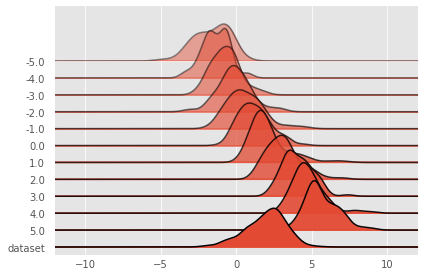

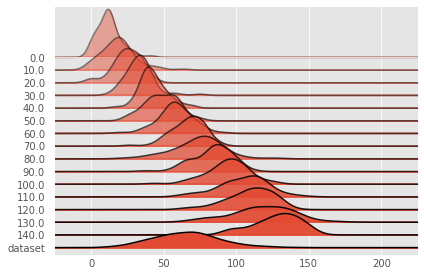

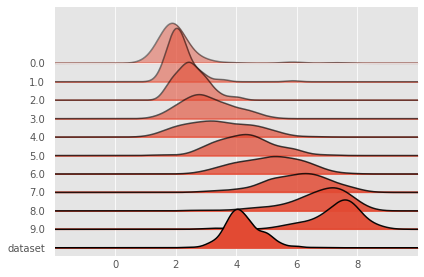

In [12]:
logp_map = defaultdict(list)
for i in sorted(logp_data, key=lambda x:x[0]):
    logp_map[i[0]].append(i[1])
logp_map['dataset'] = dataset_logP

tpsa_map = defaultdict(list)
for i in sorted(tpsa_data, key=lambda x:x[0]):
    tpsa_map[i[0]].append(i[1])
tpsa_map['dataset'] = [x*10 for x in dataset_tpsa]

# qed_map = defaultdict(list)
# for i in sorted(qed_data, key=lambda x:x[0]):
#     qed_map[i[0]].append(i[1])
# qed_map['dataset'] = dataset_qed

sas_map = defaultdict(list)
for i in sorted(sas_data, key=lambda x:x[0]):
    sas_map[i[0]].append(i[1])
sas_map['dataset'] = dataset_sas

joypy.joyplot(logp_map, grid=True, fade=True, x_range=(-12, 12))#, labels=keys)
#plt.xticks(range(-5, 6))
#plt.xlabel('Predicted Property')
#plt.ylabel('Requested Property')
#plt.title('LogP')

joypy.joyplot(tpsa_map, grid=True, fade=True, x_range=(-25, 225))#, labels=keys)
# #plt.xticks(range(-5, 6))
# plt.xlabel('Predicted Property')
# plt.ylabel('Requested Property')
# plt.title('TPSA')

# joypy.joyplot(qed_map, grid=True, fade=True)#, labels=keys)
# #plt.xticks(range(0, 11))
# # plt.xlim(-5, 6)
# plt.xlabel('Predicted Property')
# plt.ylabel('Requested Property')
# plt.title('QED')

joypy.joyplot(sas_map, grid=True, fade=True, x_range=(-2, 10))#, labels=keys)
# plt.xticks(range(0, 11))
# # plt.xlim(-5, 6)
# plt.xlabel('Predicted Property')
# plt.ylabel('Requested Property')
# plt.title('SA Score')

plt.show()

In [13]:
x = np.array(logp_data)
print('logp ', r2_score(x[:, 0], x[:, 1]))

x = np.array(tpsa_data)
print('tpsa ', r2_score(x[:, 0], x[:, 1]))

x = np.array(sas_data)
print('sas ', r2_score(x[:, 0], x[:, 1]))

logp  0.5362847151821988
tpsa  0.8704573011469146
sas  0.7334622449101603


In [30]:
novel_smiles = []
for p_smiles in tqdm(set(pred_smiles)):
    if p_smiles not in dataset_smiles:
        novel_smiles.append(p_smiles)

In [31]:
len(pred_smiles), len(set(pred_smiles)), len(set(novel_smiles))

(9552, 9367, 9362)

In [ ]:
pred_smiles

In [ ]:
idx = torch.randint(len(dataset)//2, len(dataset), (1,))
smiles = dataset.data[idx]

valids = []
scores = []
for i in range(10):
    z, v, s = reconstruct(smiles, deterministic=False)
    valids.append(v)
    scores.append(s)
    #break
    
print(valids, scores)
print(torch.tensor(valids, dtype=float).mean().item(), torch.tensor(scores, dtype=float).mean().item())

In [ ]:
plt.figure(figsize=(32, 32))
run('')

In [ ]:
idx = torch.randint(len(dataset)//2, len(dataset), (1,))
#idx = 20
smiles = dataset.data[idx]
mol = Chem.MolFromSmiles(smiles)
Draw.MolToMPL(mol); plt.show()
#edge_list, node_list, emb, valid, similarity = run_network(smiles)
G = run(smiles)

In [ ]:
#smiles = 'C(=O)C=CCC=C'
#smiles = 'C'
smiles='CC(=O)NC1=CC=CC=C1C(=O)O'
#reconstruct(smiles)
# smiles='C1=CC=C(C(=C1)C(=O)OC2=CC=CC=C2C(=O)O)O'
# smiles='CCC[NH2+]C1CCC(O)(Cc2nc(C)cs2)CC1'
# smiles='C#CCOCC1CCN(C(=O)c2ccc(S(=O)(=O)N3CCCC[C@H]3C)cc2)CC1'
# smiles='Cc1cccc2sc(NC(=O)[C@H](C)N3C(=O)[C@@H]4CC=CC[C@H]4C3=O)nc12'
# smiles='Cc1cc(C(=O)Nc2ccc(OCC(N)=O)cc2)c(C)n1C1CC1'
# smiles='CCOc1ccc2nc(N(C[C@@H]3CCCO3)C(=O)c3ccccc3S(C)(=O)=O)sc2c1'
# smiles='COc1cc(C(=O)N(Cc2cccc(F)c2)[C@H]2CCS(=O)(=O)C2)cc(OC)c1OC'
mol = Chem.MolFromSmiles(smiles)
Draw.MolToMPL(mol); plt.show()
#G = mol2graph(mol)[0]
#G.to(DEVICE)
#mu, var = enc(G)
run(smiles)

In [ ]:
mol